# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 16            
model_seed = 6           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.1021,  0.0762],
        [ 0.6885,  0.1528],
        [-0.3753, -0.0719],
        [ 0.2465,  0.3507],
        [ 0.0850, -0.4704]], device='cuda:0')

model.0.bias (first 5 values):
tensor([-0.0888,  0.1812,  0.5023, -0.1352, -0.2185], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.7000 | Test Loss 0.6939 | accs Train 0.4825 Test 0.5000


Epoch 100/2000: Train Loss 0.5759 | Test Loss 0.6084 | accs Train 0.6725 Test 0.6398


Epoch 200/2000: Train Loss 0.0240 | Test Loss 0.0385 | accs Train 0.9975 Test 0.9905


Epoch 300/2000: Train Loss 0.0012 | Test Loss 0.0157 | accs Train 1.0000 Test 0.9945


Epoch 400/2000: Train Loss 0.0004 | Test Loss 0.0146 | accs Train 1.0000 Test 0.9950


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0138 | accs Train 1.0000 Test 0.9955


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0139 | accs Train 1.0000 Test 0.9960


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0138 | accs Train 1.0000 Test 0.9960


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0133 | accs Train 1.0000 Test 0.9960


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0130 | accs Train 1.0000 Test 0.9960


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0127 | accs Train 1.0000 Test 0.9960


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0127 | accs Train 1.0000 Test 0.9962


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0125 | accs Train 1.0000 Test 0.9962


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0124 | accs Train 1.0000 Test 0.9962


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0123 | accs Train 1.0000 Test 0.9970


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0123 | accs Train 1.0000 Test 0.9972


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0123 | accs Train 1.0000 Test 0.9972


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0131 | accs Train 1.0000 Test 0.9970


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0135 | accs Train 1.0000 Test 0.9970


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0138 | accs Train 1.0000 Test 0.9970


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0140 | accs Train 1.0000 Test 0.9970
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6995 | Test Loss 0.6938 | accs Train 0.4854 Test 0.5000


Epoch 100/2000: Train Loss 0.5842 | Test Loss 0.6139 | accs Train 0.6683 Test 0.6392


Epoch 200/2000: Train Loss 0.1101 | Test Loss 0.0709 | accs Train 0.9732 Test 0.9888


Epoch 300/2000: Train Loss 0.0570 | Test Loss 0.0387 | accs Train 0.9805 Test 0.9925


Epoch 400/2000: Train Loss 0.0415 | Test Loss 0.0425 | accs Train 0.9829 Test 0.9880


Epoch 500/2000: Train Loss 0.0350 | Test Loss 0.0600 | accs Train 0.9829 Test 0.9780


Epoch 600/2000: Train Loss 0.0284 | Test Loss 0.0792 | accs Train 0.9927 Test 0.9720


Epoch 700/2000: Train Loss 0.0223 | Test Loss 0.0862 | accs Train 0.9927 Test 0.9725


Epoch 800/2000: Train Loss 0.0188 | Test Loss 0.0991 | accs Train 0.9951 Test 0.9720


Epoch 900/2000: Train Loss 0.0161 | Test Loss 0.1070 | accs Train 0.9951 Test 0.9725


Epoch 1000/2000: Train Loss 0.0134 | Test Loss 0.1211 | accs Train 0.9951 Test 0.9712


Epoch 1100/2000: Train Loss 0.0118 | Test Loss 0.1334 | accs Train 0.9951 Test 0.9725


Epoch 1200/2000: Train Loss 0.0097 | Test Loss 0.1399 | accs Train 0.9976 Test 0.9748


Epoch 1300/2000: Train Loss 0.0083 | Test Loss 0.1600 | accs Train 0.9976 Test 0.9738


Epoch 1400/2000: Train Loss 0.0075 | Test Loss 0.1753 | accs Train 0.9976 Test 0.9718


Epoch 1500/2000: Train Loss 0.0065 | Test Loss 0.1796 | accs Train 1.0000 Test 0.9732


Epoch 1600/2000: Train Loss 0.0060 | Test Loss 0.1867 | accs Train 1.0000 Test 0.9742


Epoch 1700/2000: Train Loss 0.0054 | Test Loss 0.1943 | accs Train 1.0000 Test 0.9738


Epoch 1800/2000: Train Loss 0.0048 | Test Loss 0.2018 | accs Train 1.0000 Test 0.9738


Epoch 1900/2000: Train Loss 0.0057 | Test Loss 0.2115 | accs Train 0.9976 Test 0.9725


Epoch 2000/2000: Train Loss 0.0041 | Test Loss 0.2294 | accs Train 0.9976 Test 0.9705
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6997 | Test Loss 0.6939 | accs Train 0.4833 Test 0.5000


Epoch 100/2000: Train Loss 0.5891 | Test Loss 0.6108 | accs Train 0.6667 Test 0.6378


Epoch 200/2000: Train Loss 0.1773 | Test Loss 0.1138 | accs Train 0.9476 Test 0.9765


Epoch 300/2000: Train Loss 0.0983 | Test Loss 0.0671 | accs Train 0.9619 Test 0.9825


Epoch 400/2000: Train Loss 0.0819 | Test Loss 0.0710 | accs Train 0.9667 Test 0.9760


Epoch 500/2000: Train Loss 0.0735 | Test Loss 0.0744 | accs Train 0.9690 Test 0.9770


Epoch 600/2000: Train Loss 0.0700 | Test Loss 0.0760 | accs Train 0.9690 Test 0.9690


Epoch 700/2000: Train Loss 0.0616 | Test Loss 0.0849 | accs Train 0.9714 Test 0.9683


Epoch 800/2000: Train Loss 0.0557 | Test Loss 0.0933 | accs Train 0.9833 Test 0.9665


Epoch 900/2000: Train Loss 0.0530 | Test Loss 0.1012 | accs Train 0.9786 Test 0.9665


Epoch 1000/2000: Train Loss 0.0664 | Test Loss 0.1235 | accs Train 0.9714 Test 0.9625


Epoch 1100/2000: Train Loss 0.0463 | Test Loss 0.1022 | accs Train 0.9857 Test 0.9650


Epoch 1200/2000: Train Loss 0.0438 | Test Loss 0.1073 | accs Train 0.9857 Test 0.9647


Epoch 1300/2000: Train Loss 0.0414 | Test Loss 0.1122 | accs Train 0.9881 Test 0.9640


Epoch 1400/2000: Train Loss 0.0394 | Test Loss 0.1175 | accs Train 0.9881 Test 0.9635


Epoch 1500/2000: Train Loss 0.0412 | Test Loss 0.1336 | accs Train 0.9881 Test 0.9610


Epoch 1600/2000: Train Loss 0.0422 | Test Loss 0.1316 | accs Train 0.9762 Test 0.9595


Epoch 1700/2000: Train Loss 0.0496 | Test Loss 0.1962 | accs Train 0.9810 Test 0.9610


Epoch 1800/2000: Train Loss 0.0367 | Test Loss 0.1288 | accs Train 0.9857 Test 0.9635


Epoch 1900/2000: Train Loss 0.0319 | Test Loss 0.1366 | accs Train 0.9905 Test 0.9615


Epoch 2000/2000: Train Loss 0.0309 | Test Loss 0.1451 | accs Train 0.9905 Test 0.9615
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6996 | Test Loss 0.6939 | accs Train 0.4822 Test 0.5000


Epoch 100/2000: Train Loss 0.6027 | Test Loss 0.6105 | accs Train 0.6489 Test 0.6380


Epoch 200/2000: Train Loss 0.3253 | Test Loss 0.2485 | accs Train 0.8867 Test 0.9400


Epoch 300/2000: Train Loss 0.2388 | Test Loss 0.1773 | accs Train 0.8978 Test 0.9430


Epoch 400/2000: Train Loss 0.2112 | Test Loss 0.1866 | accs Train 0.9133 Test 0.9343


Epoch 500/2000: Train Loss 0.1896 | Test Loss 0.1979 | accs Train 0.9222 Test 0.9325


Epoch 600/2000: Train Loss 0.1757 | Test Loss 0.2164 | accs Train 0.9289 Test 0.9245


Epoch 700/2000: Train Loss 0.1643 | Test Loss 0.2421 | accs Train 0.9356 Test 0.9223


Epoch 800/2000: Train Loss 0.1580 | Test Loss 0.2858 | accs Train 0.9378 Test 0.9145


Epoch 900/2000: Train Loss 0.1502 | Test Loss 0.2878 | accs Train 0.9378 Test 0.9097


Epoch 1000/2000: Train Loss 0.1383 | Test Loss 0.3093 | accs Train 0.9444 Test 0.9105


Epoch 1100/2000: Train Loss 0.1355 | Test Loss 0.3405 | accs Train 0.9422 Test 0.9050


Epoch 1200/2000: Train Loss 0.1284 | Test Loss 0.3622 | accs Train 0.9467 Test 0.9077


Epoch 1300/2000: Train Loss 0.1252 | Test Loss 0.3638 | accs Train 0.9489 Test 0.9073


Epoch 1400/2000: Train Loss 0.1269 | Test Loss 0.3671 | accs Train 0.9444 Test 0.9042


Epoch 1500/2000: Train Loss 0.1171 | Test Loss 0.3845 | accs Train 0.9422 Test 0.9062


Epoch 1600/2000: Train Loss 0.1146 | Test Loss 0.4136 | accs Train 0.9467 Test 0.9030


Epoch 1700/2000: Train Loss 0.1131 | Test Loss 0.4212 | accs Train 0.9511 Test 0.8980


Epoch 1800/2000: Train Loss 0.1097 | Test Loss 0.4395 | accs Train 0.9533 Test 0.9045


Epoch 1900/2000: Train Loss 0.1117 | Test Loss 0.4626 | accs Train 0.9467 Test 0.9012


Epoch 2000/2000: Train Loss 0.1071 | Test Loss 0.4484 | accs Train 0.9467 Test 0.8988
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6972 | Test Loss 0.6939 | accs Train 0.4980 Test 0.5000


Epoch 100/2000: Train Loss 0.6304 | Test Loss 0.6182 | accs Train 0.6220 Test 0.6335


Epoch 200/2000: Train Loss 0.4920 | Test Loss 0.3947 | accs Train 0.7860 Test 0.8688


Epoch 300/2000: Train Loss 0.4279 | Test Loss 0.3038 | accs Train 0.8140 Test 0.9085


Epoch 400/2000: Train Loss 0.3997 | Test Loss 0.2919 | accs Train 0.8220 Test 0.8995


Epoch 500/2000: Train Loss 0.3752 | Test Loss 0.3058 | accs Train 0.8320 Test 0.8878


Epoch 600/2000: Train Loss 0.3603 | Test Loss 0.3204 | accs Train 0.8380 Test 0.8880


Epoch 700/2000: Train Loss 0.3342 | Test Loss 0.3357 | accs Train 0.8460 Test 0.8758


Epoch 800/2000: Train Loss 0.3242 | Test Loss 0.3773 | accs Train 0.8540 Test 0.8592


Epoch 900/2000: Train Loss 0.2991 | Test Loss 0.4007 | accs Train 0.8720 Test 0.8458


Epoch 1000/2000: Train Loss 0.2862 | Test Loss 0.4246 | accs Train 0.8720 Test 0.8492


Epoch 1100/2000: Train Loss 0.2788 | Test Loss 0.4625 | accs Train 0.8780 Test 0.8417


Epoch 1200/2000: Train Loss 0.2802 | Test Loss 0.4881 | accs Train 0.8740 Test 0.8355


Epoch 1300/2000: Train Loss 0.2607 | Test Loss 0.5077 | accs Train 0.8800 Test 0.8300


Epoch 1400/2000: Train Loss 0.2547 | Test Loss 0.5314 | accs Train 0.8860 Test 0.8280


Epoch 1500/2000: Train Loss 0.2526 | Test Loss 0.5612 | accs Train 0.8840 Test 0.8267


Epoch 1600/2000: Train Loss 0.2381 | Test Loss 0.5747 | accs Train 0.8940 Test 0.8190


Epoch 1700/2000: Train Loss 0.2488 | Test Loss 0.6156 | accs Train 0.8880 Test 0.7980


Epoch 1800/2000: Train Loss 0.2312 | Test Loss 0.6218 | accs Train 0.8940 Test 0.8075


Epoch 1900/2000: Train Loss 0.2224 | Test Loss 0.6349 | accs Train 0.9040 Test 0.8073


Epoch 2000/2000: Train Loss 0.2173 | Test Loss 0.6295 | accs Train 0.9040 Test 0.8120
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0140 | accs: 0.9970
  10 samples | Test Loss: 0.2294 | accs: 0.9705
  20 samples | Test Loss: 0.1451 | accs: 0.9615
  50 samples | Test Loss: 0.4484 | accs: 0.8988
 100 samples | Test Loss: 0.6295 | accs: 0.8120

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0029 | accs: 1.0000
 Model   20 | Train Loss: 0.0167 | accs: 0.9975
 Model   50 | Train Loss: 0.0491 | accs: 0.9875
 Model  100 | Train Loss: 0.1175 | accs: 0.9775

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3686 | accs: 0.9756
 Model   10 | Train Loss: 0.0042 | accs: 1.0000
 Model   20 | Train Loss: 0.0248 | accs: 0.9927
 Model   50 | Train Loss: 0.0733 | accs: 0.9732
 Model  100 | Train Loss: 0.1322 | accs: 0.9659

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6954 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

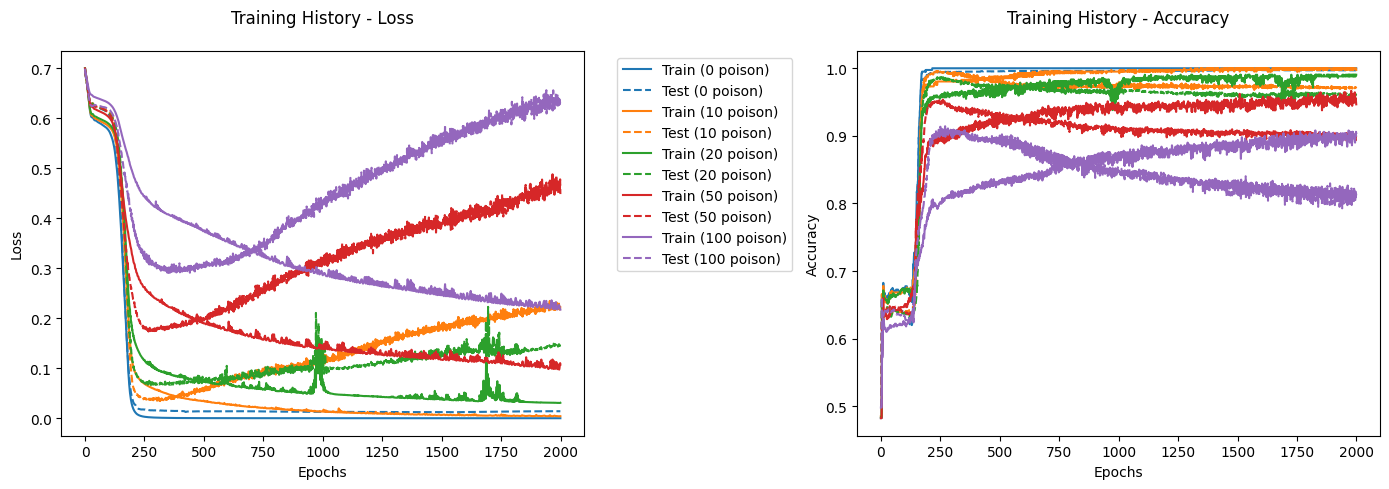

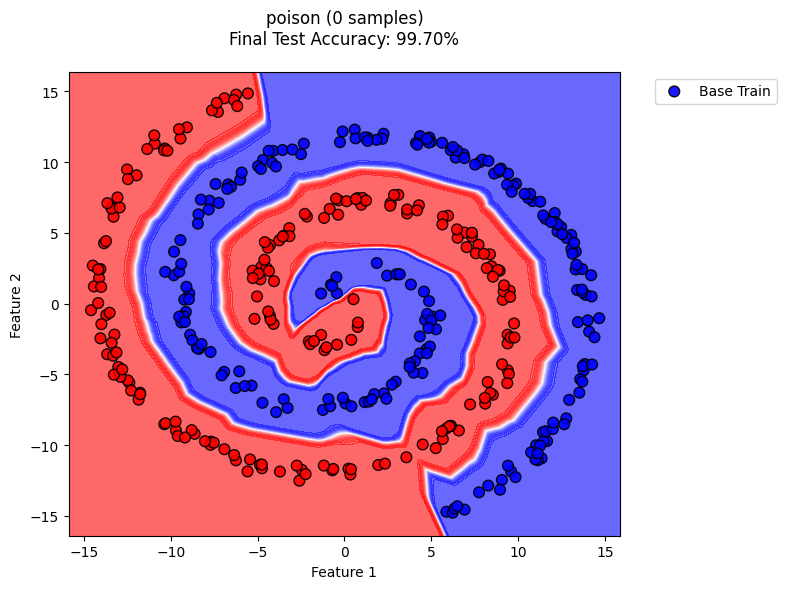

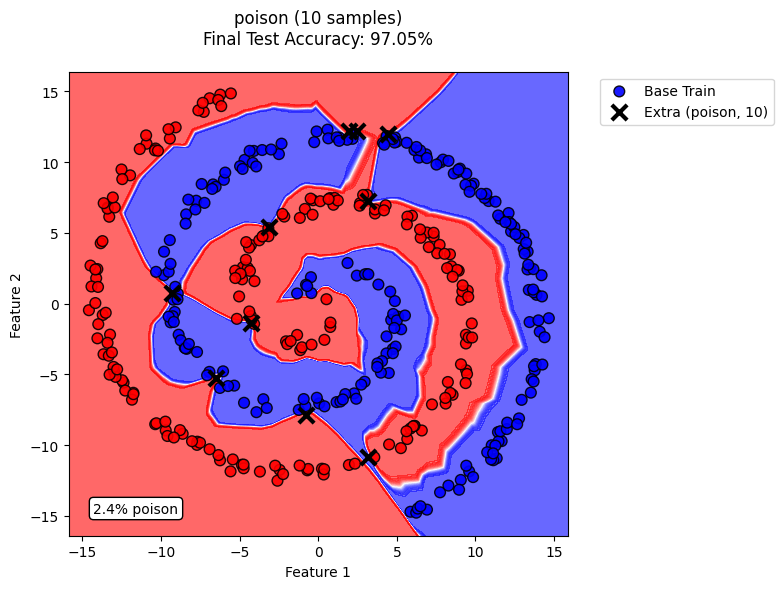

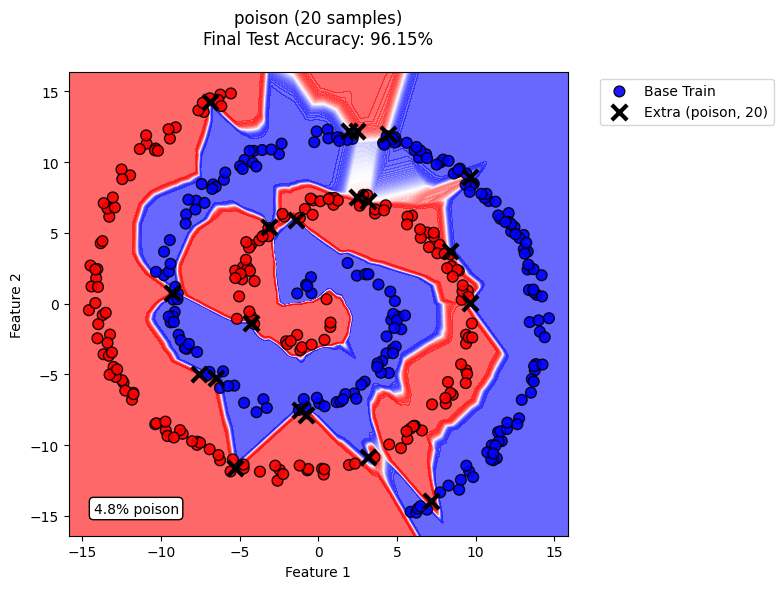

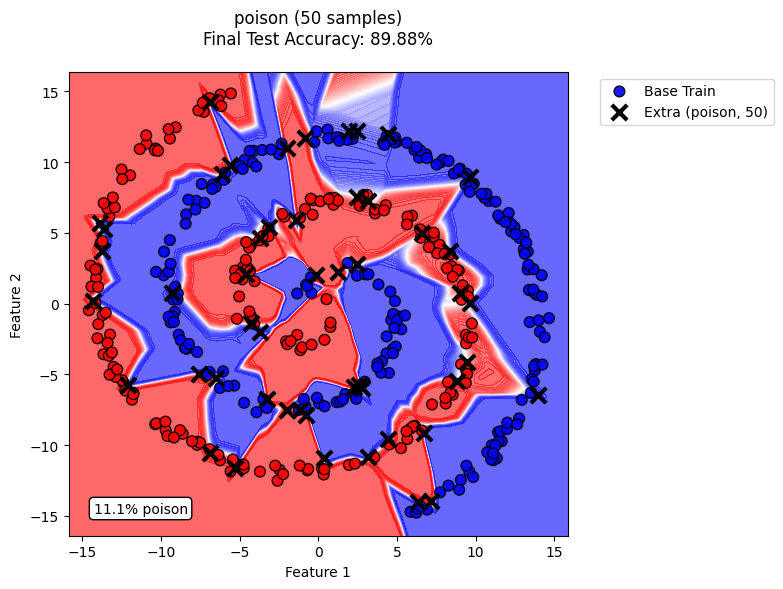

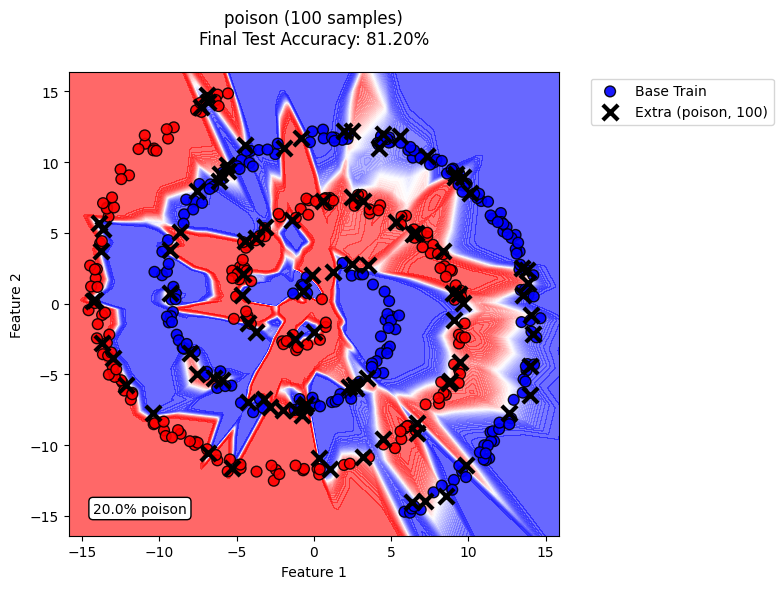

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
